In [75]:
import pandas as pd
import os
from datetime import datetime, timedelta
import glob
import pandas as pd
import random
import numpy as np
import seaborn as sns
import ast
import json
import os
import re
import itertools
import folium
import hdbscan
import h3

from scipy.spatial.transform import Rotation as R
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.patches as patches
from pydp.algorithms.numerical_mechanisms import LaplaceMechanism
from itertools import combinations
from collections import defaultdict
from collections import Counter
from typing import Dict, Set, List, Optional, Tuple

In [76]:
df_gps = pd.read_csv("C:\\Users\\dmc\\Desktop\\extracted_trips_data.csv")

df_people = pd.read_csv("C:\\Users\\dmc\\Desktop\\individuals_dataset.csv")
df_people = df_people[df_people['GPS_RECORD'] == True]

df_merged = pd.merge(
    df_gps,
    df_people[['ID', 'SEX', 'AGE', 'PRO_CAT', 'WEIGHT_INDIV']],
    left_on='person_id',
    right_on='ID',
    how='inner'
).drop(columns='ID')

h3_resolution = 10

df_merged['start_h3'] = df_merged.apply(lambda row: h3.latlng_to_cell(row['start_lat'], row['start_lon'], h3_resolution), axis=1)
df_merged['end_h3'] = df_merged.apply(lambda row: h3.latlng_to_cell(row['end_lat'], row['end_lon'], h3_resolution), axis=1)

media_peso = df_merged['WEIGHT_INDIV'].mean()

In [ ]:
mode = "SEX"
# mode = "AGE"
# mode = "PRO_CAT"

In [78]:
if mode == "SEX":
    df_man = df_merged[df_merged["SEX"] == "Man"]
    df_woman = df_merged[df_merged["SEX"] == "Woman"]
    print("Split fatto per SEX")
    
elif mode == "AGE":
    df_10_19 = df_merged[(df_merged["AGE"] >= 10) & (df_merged["AGE"] <= 19)]
    df_20_29 = df_merged[(df_merged["AGE"] >= 20) & (df_merged["AGE"] <= 29)]
    df_30_39 = df_merged[(df_merged["AGE"] >= 30) & (df_merged["AGE"] <= 39)]
    df_40_49 = df_merged[(df_merged["AGE"] >= 40) & (df_merged["AGE"] <= 49)]
    df_50_59 = df_merged[(df_merged["AGE"] >= 50) & (df_merged["AGE"] <= 59)]
    df_60_69 = df_merged[(df_merged["AGE"] >= 60) & (df_merged["AGE"] <= 69)]
    df_over70 = df_merged[(df_merged["AGE"] >= 70)]
    print("Split fatto per AGE")
    
elif mode == "PRO_CAT":
    df_procat_1 = df_merged[df_merged["PRO_CAT"] == 1]
    df_procat_2 = df_merged[df_merged["PRO_CAT"] == 2]
    df_procat_3 = df_merged[df_merged["PRO_CAT"] == 3]
    df_procat_4 = df_merged[df_merged["PRO_CAT"] == 4]
    df_procat_5 = df_merged[df_merged["PRO_CAT"] == 5]
    df_procat_6 = df_merged[df_merged["PRO_CAT"] == 6]
    df_procat_7 = df_merged[df_merged["PRO_CAT"] == 7]
    df_procat_8 = df_merged[df_merged["PRO_CAT"] == 8]
    print("Split fatto per PRO_CAT")
    
else:
    print("⚠️ Mode non valido: scegli tra 'SEX', 'AGE', 'PRO_CAT'")

Split fatto per SEX


In [79]:
import pandas as pd
import h3

# Lista degli esagoni H3 target
target_hexagons = {
    "861fb4667ffffff",
    "861fb4677ffffff", 
    "861fb466fffffff",
    "861fb4647ffffff",
    "861fb475fffffff"
}

def filter_by_h3_hexagons(df, target_hexagons, resolution=6):
    """
    Filtra il dataset mantenendo solo le righe dove sia start che end
    si trovano negli esagoni H3 specificati.
    
    Parameters:
    - df: DataFrame con colonne start_lat, start_lon, end_lat, end_lon
    - target_hexagons: set degli esagoni H3 target
    - resolution: risoluzione H3 (default 7, basata sui tuoi esagoni)
    
    Returns:
    - DataFrame filtrato
    """
    
    # Aggiungi colonne con gli esagoni H3 per start e end
    df['start_h3'] = df.apply(lambda row: h3.latlng_to_cell(row['start_lat'], row['start_lon'], resolution), axis=1)
    df['end_h3'] = df.apply(lambda row: h3.latlng_to_cell(row['end_lat'], row['end_lon'], resolution), axis=1)
    
    # Filtra le righe dove sia start che end sono negli esagoni target
    filtered_df = df[
        (df['start_h3'].isin(target_hexagons)) & 
        (df['end_h3'].isin(target_hexagons))
    ].copy()
    
    print(f"Righe originali: {len(df)}")
    print(f"Righe filtrate: {len(filtered_df)}")
    print(f"Percentuale mantenuta: {len(filtered_df)/len(df)*100:.2f}%")
    
    return filtered_df

if mode == "SEX":
    print("\n--- FILTRO SEX ---")
    df_man = filter_by_h3_hexagons(df_man, target_hexagons)
    df_woman = filter_by_h3_hexagons(df_woman, target_hexagons)
    print("✓ Filtrati df_man e df_woman")

elif mode == "AGE":
    print("\n--- FILTRO AGE ---")
    df_10_19 = filter_by_h3_hexagons(df_10_19, target_hexagons)
    df_20_29 = filter_by_h3_hexagons(df_20_29, target_hexagons)
    df_30_39 = filter_by_h3_hexagons(df_30_39, target_hexagons)
    df_40_49 = filter_by_h3_hexagons(df_40_49, target_hexagons)
    df_50_59 = filter_by_h3_hexagons(df_50_59, target_hexagons)
    df_60_69 = filter_by_h3_hexagons(df_60_69, target_hexagons)
    df_over70 = filter_by_h3_hexagons(df_over70, target_hexagons)
    print("✓ Filtrati tutti i dataframe per età")

elif mode == "PRO_CAT":
    print("\n--- FILTRO PRO_CAT ---")
    for i in range(1, 9):
        globals()[f"df_procat_{i}"] = filter_by_h3_hexagons(
            globals()[f"df_procat_{i}"], 
            target_hexagons
        )
        print(f"✓ Filtrato df_procat_{i}")

else:
    print("⚠️ Mode non valido: scegli tra 'SEX', 'AGE', 'PRO_CAT'")


--- FILTRO SEX ---


C:\Users\dmc\AppData\Local\Temp\ipykernel_5972\2660262652.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_h3'] = df.apply(lambda row: h3.latlng_to_cell(row['start_lat'], row['start_lon'], resolution), axis=1)
C:\Users\dmc\AppData\Local\Temp\ipykernel_5972\2660262652.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_h3'] = df.apply(lambda row: h3.latlng_to_cell(row['end_lat'], row['end_lon'], resolution), axis=1)


Righe originali: 36754
Righe filtrate: 13450
Percentuale mantenuta: 36.59%
Righe originali: 44535
Righe filtrate: 15042
Percentuale mantenuta: 33.78%
✓ Filtrati df_man e df_woman


In [80]:
cols_to_drop = ['start_h3', 'end_h3', 'SEX', 'AGE', 'PRO_CAT']

if mode == "SEX":
    print("\n--- DROP COLONNE SEX ---")
    df_man.drop(columns=cols_to_drop, inplace=True, errors="ignore")
    df_woman.drop(columns=cols_to_drop, inplace=True, errors="ignore")
    print("✓ Colonne rimosse da df_man e df_woman")

elif mode == "AGE":
    print("\n--- DROP COLONNE AGE ---")
    for label in ["10_19", "20_29", "30_39", "40_49", "50_59", "60_69", "over70"]:
        globals()[f"df_{label}"].drop(columns=cols_to_drop, inplace=True, errors="ignore")
        print(f"✓ Colonne rimosse da df_{label}")

elif mode == "PRO_CAT":
    print("\n--- DROP COLONNE PRO_CAT ---")
    for i in range(1, 9):
        globals()[f"df_procat_{i}"].drop(columns=cols_to_drop, inplace=True, errors="ignore")
        print(f"✓ Colonne rimosse da df_procat_{i}")

else:
    print("⚠️ Mode non valido: scegli tra 'SEX', 'AGE', 'PRO_CAT'")



--- DROP COLONNE SEX ---
✓ Colonne rimosse da df_man e df_woman


In [81]:
categorical = set((
    'person_id',
    'start_time',
    'end_time',
))

def getSpans(df, partition, scale=None):
    """
    :param        df: the dataframe for which to calculate the spans
    :param partition: the partition for which to calculate the spans
    :param     scale: if given, the spans of each column will be divided
                      by the value in `scale` for that column
    :        returns: The spans of all columns in the partition
    """
    spans = {}
    for column in df.columns:
        if column in categorical:
            span = len(df[column][partition].unique())
        else:
            span = df[column][partition].max()-df[column][partition].min()
        if scale is not None:
            span = span/scale[column]
        spans[column] = span
    return spans

if mode == "SEX":
    print("\n--- GET SPANS SEX ---")
    fullSpans_man = getSpans(df_man, df_man.index)
    fullSpans_woman = getSpans(df_woman, df_woman.index)
    print("✓ Calcolati fullSpans_man e fullSpans_woman")

elif mode == "AGE":
    print("\n--- GET SPANS AGE ---")
    for label in ["10_19", "20_29", "30_39", "40_49", "50_59", "60_69", "over70"]:
        globals()[f"fullSpans_{label}"] = getSpans(
            globals()[f"df_{label}"],
            globals()[f"df_{label}"].index
        )
        print(f"✓ Calcolato fullSpans_{label}")

elif mode == "PRO_CAT":
    print("\n--- GET SPANS PRO_CAT ---")
    for i in range(1, 9):
        globals()[f"fullSpans_procat_{i}"] = getSpans(
            globals()[f"df_procat_{i}"],
            globals()[f"df_procat_{i}"].index
        )
        print(f"✓ Calcolato fullSpans_procat_{i}")

else:
    print("⚠️ Mode non valido: scegli tra 'SEX', 'AGE', 'PRO_CAT'")

def split(df, partition, column):
    """
    :param        df: The dataframe to split
    :param partition: The partition to split
    :param    column: The column along which to split
    :        returns: A tuple containing a split of the original partition
    """
    dfp = df[column][partition]
    if column in categorical:
        values = dfp.unique()
        lv = set(values[:len(values)//2])
        rv = set(values[len(values)//2:])
        return dfp.index[dfp.isin(lv)], dfp.index[dfp.isin(rv)]
    else:        
        median = dfp.median()
        dfl = dfp.index[dfp < median]
        dfr = dfp.index[dfp >= median]
        return (dfl, dfr)

def isKAnonymous(df, partition, sensitiveColumn, k=10):
    """
    :param               df: The dataframe on which to check the partition.
    :param        partition: The partition of the dataframe to check.
    :param sensitiveColumn: The name of the sensitive column
    :param                k: The desired k
    :returns               : True if the partition is valid according to our k-anonymity criteria, False otherwise.
    """
    if len(partition) < k:
        return False
    return True

def partitionDataset(df, featureColumns, sensitiveColumn, scale, isValid):
    """
    :param               df: The dataframe to be partitioned.
    :param  featureColumns: A list of column names along which to partition the dataset.
    :param sensitiveColumn: The name of the sensitive column (to be passed on to the `isValid` function)
    :param            scale: The column spans as generated before.
    :param         isValid: A function that takes a dataframe and a partition and returns True if the partition is valid.
    :returns               : A list of valid partitions that cover the entire dataframe.
    """
    finishedPartitions = [] # Contiene le partizioni che rispettano k-anonimity
    partitions = [df.index] # Inizialmente tutto il dataset è una partizione

    # Continua a partizionare finché ci sono partizioni non ancora verificate
    while partitions:
        partition = partitions.pop(0) # Estrai una partizione da analizzare
        spans = getSpans(df[featureColumns], partition, scale)
        # Ordina gli span dal più ampio al più piccolo
        for column, span in sorted(spans.items(), key=lambda x:-x[1]):
            # Suddividi la partizione sulla colonna con lo span più ampio
            lp, rp = split(df, partition, column)
            if not isValid(df, lp, sensitiveColumn) or not isValid(df, rp, sensitiveColumn):
                continue
            partitions.extend((lp, rp))
            break
        else:
            finishedPartitions.append(partition)
    return finishedPartitions


--- GET SPANS SEX ---
✓ Calcolati fullSpans_man e fullSpans_woman


In [82]:
featureColumns = ['start_lon', 'start_lat', 'end_lon', 'end_lat']
sensitiveColumn = 'person_id'

if mode == "SEX":
    print("\n--- PARTITION SEX ---")
    print("\n[Man]")
    finishedPartitions_man = partitionDataset(
        df_man,
        featureColumns,
        sensitiveColumn,
        fullSpans_man,
        isKAnonymous
    )
    print("✓ Partition completata per Man")

    print("\n[Woman]")
    finishedPartitions_woman = partitionDataset(
        df_woman,
        featureColumns,
        sensitiveColumn,
        fullSpans_woman,
        isKAnonymous
    )
    print("✓ Partition completata per Woman")

elif mode == "AGE":
    print("\n--- PARTITION AGE ---")
    for label in ["10_19", "20_29", "30_39", "40_49", "50_59", "60_69", "over70"]:
        print(f"\n[{label}]")
        globals()[f"finishedPartitions_{label}"] = partitionDataset(
            globals()[f"df_{label}"],
            featureColumns,
            sensitiveColumn,
            globals()[f"fullSpans_{label}"],
            isKAnonymous
        )
        print(f"✓ Partition completata per {label}")

elif mode == "PRO_CAT":
    print("\n--- PARTITION PRO_CAT ---")
    for i in range(1, 9):
        print(f"\n[Category {i}]")
        globals()[f"finishedPartitions_procat_{i}"] = partitionDataset(
            globals()[f"df_procat_{i}"],
            featureColumns,
            sensitiveColumn,
            globals()[f"fullSpans_procat_{i}"],
            isKAnonymous
        )
        print(f"✓ Partition completata per Category {i}")

else:
    print("⚠️ Mode non valido: scegli tra 'SEX', 'AGE', 'PRO_CAT'")



--- PARTITION SEX ---

[Man]
✓ Partition completata per Man

[Woman]
✓ Partition completata per Woman


In [83]:
if mode == "SEX":
    print("\n--- LENGTH FINISHED PARTITIONS SEX ---")
    print(f"Man: {len(finishedPartitions_man)} partizioni")
    print(f"Woman: {len(finishedPartitions_woman)} partizioni")

elif mode == "AGE":
    print("\n--- LENGTH FINISHED PARTITIONS AGE ---")
    for label in ["10_19", "20_29", "30_39", "40_49", "50_59", "60_69", "over70"]:
        length = len(globals()[f"finishedPartitions_{label}"])
        print(f"{label}: {length} partizioni")

elif mode == "PRO_CAT":
    print("\n--- LENGTH FINISHED PARTITIONS PRO_CAT ---")
    for i in range(1, 9):
        length = len(globals()[f"finishedPartitions_procat_{i}"])
        print(f"Category {i}: {length} partizioni")

else:
    print("⚠️ Mode non valido: scegli tra 'SEX', 'AGE', 'PRO_CAT'")



--- LENGTH FINISHED PARTITIONS SEX ---
Man: 1022 partizioni
Woman: 1031 partizioni



--- PLOT PARTIZIONI SEX ---


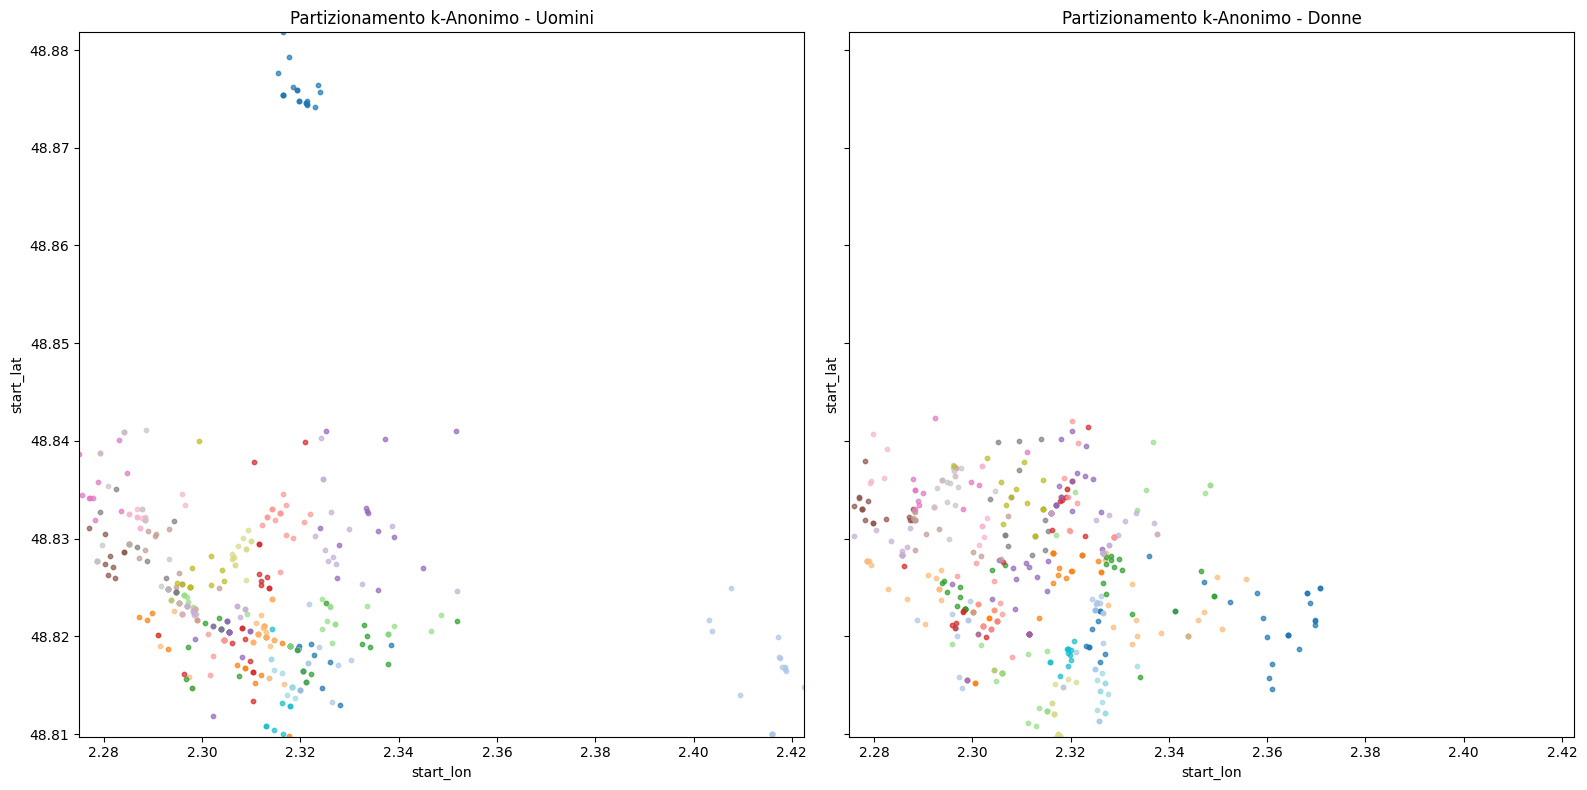

In [84]:
import matplotlib.pyplot as plt

max_partitions = 30
colors = plt.colormaps['tab20']
feature_x = 'start_lon'
feature_y = 'start_lat'

if mode == "SEX":
    print("\n--- PLOT PARTIZIONI SEX ---")

    all_lon = pd.concat([df_merged.loc[p][feature_x] for p in finishedPartitions_man[:max_partitions]] +
                        [df_merged.loc[p][feature_x] for p in finishedPartitions_woman[:max_partitions]])
    all_lat = pd.concat([df_merged.loc[p][feature_y] for p in finishedPartitions_man[:max_partitions]] +
                        [df_merged.loc[p][feature_y] for p in finishedPartitions_woman[:max_partitions]])

    min_lon, max_lon = all_lon.min(), all_lon.max()
    min_lat, max_lat = all_lat.min(), all_lat.max()

    fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)

    for i, partition in enumerate(finishedPartitions_man[:max_partitions]):
        partition_data = df_merged.loc[partition]
        axes[0].scatter(partition_data[feature_x], partition_data[feature_y],
                        s=10, alpha=0.7, color=colors(i % 20), label=f'Partizione {i+1}')
    axes[0].set_title('Partizionamento k-Anonimo - Uomini')

    for i, partition in enumerate(finishedPartitions_woman[:max_partitions]):
        partition_data = df_merged.loc[partition]
        axes[1].scatter(partition_data[feature_x], partition_data[feature_y],
                        s=10, alpha=0.7, color=colors(i % 20), label=f'Partizione {i+1}')
    axes[1].set_title('Partizionamento k-Anonimo - Donne')

    for ax in axes:
        ax.set_xlabel(feature_x)
        ax.set_ylabel(feature_y)
        ax.set_xlim(min_lon, max_lon)
        ax.set_ylim(min_lat, max_lat)

    plt.tight_layout()
    plt.show()

elif mode == "AGE":
    print("\n--- PLOT PARTIZIONI AGE ---")
    for label in ["10_19", "20_29", "30_39", "40_49", "50_59", "60_69", "over70"]:
        print(f"\nVisualizzazione partizioni per {label}")
        partitions = globals()[f"finishedPartitions_{label}"][:max_partitions]

        all_lon = pd.concat([df_merged.loc[p][feature_x] for p in partitions])
        all_lat = pd.concat([df_merged.loc[p][feature_y] for p in partitions])
        min_lon, max_lon = all_lon.min(), all_lon.max()
        min_lat, max_lat = all_lat.min(), all_lat.max()

        plt.figure(figsize=(8, 8))
        for i, partition in enumerate(partitions):
            partition_data = df_merged.loc[partition]
            plt.scatter(partition_data[feature_x], partition_data[feature_y],
                        s=10, alpha=0.7, color=colors(i % 20), label=f'Partizione {i+1}')
        plt.title(f'Partizionamento k-Anonimo - {label}')
        plt.xlabel(feature_x)
        plt.ylabel(feature_y)
        plt.xlim(min_lon, max_lon)
        plt.ylim(min_lat, max_lat)
        plt.show()

elif mode == "PRO_CAT":
    print("\n--- PLOT PARTIZIONI PRO_CAT ---")
    for i in range(1, 9):
        print(f"\nVisualizzazione partizioni per ProCat-{i}")
        partitions = globals()[f"finishedPartitions_procat_{i}"][:max_partitions]

        all_lon = pd.concat([df_merged.loc[p][feature_x] for p in partitions])
        all_lat = pd.concat([df_merged.loc[p][feature_y] for p in partitions])
        min_lon, max_lon = all_lon.min(), all_lon.max()
        min_lat, max_lat = all_lat.min(), all_lat.max()

        plt.figure(figsize=(8, 8))
        for j, partition in enumerate(partitions):
            partition_data = df_merged.loc[partition]
            plt.scatter(partition_data[feature_x], partition_data[feature_y],
                        s=10, alpha=0.7, color=colors(j % 20), label=f'Partizione {j+1}')
        plt.title(f'Partizionamento k-Anonimo - ProCat-{i}')
        plt.xlabel(feature_x)
        plt.ylabel(feature_y)
        plt.xlim(min_lon, max_lon)
        plt.ylim(min_lat, max_lat)
        plt.show()

else:
    print("⚠️ Mode non valido: scegli tra 'SEX', 'AGE', 'PRO_CAT'")


In [85]:
def buildAnonymizedDataset(df, partitions, featureColumns, sensitiveColumn, maxPartitions=None):
    aggregations = {}
    # Per ogni colonna numerica nelle featureColumns, specifica il tipo di aggregazione da applicare (anonimizzazione tramite mediana).
    for column in featureColumns:
        aggregations[column] = aggNumericalColumn

    df_with_partitions = df.copy()
    df_with_partitions['partition_id'] = -1  # Inizializza con -1 (non assegnato)
    rows = []
    for i, partition in enumerate(partitions):
        if i % 100 == 1:
            print("Finished {} partitions...".format(i))
        if maxPartitions is not None and i > maxPartitions:
            break
        df_with_partitions.loc[partition, 'partition_id'] = i

        # Aggrega i dati solo per gli indici della partizione corrente.
        groupedColumns = df.loc[partition].agg(aggregations, squeeze=False)

        # Conta quante volte appare ogni valore della colonna sensibile (es. trip_id) all'interno della partizione.
        sensitiveCounts = df.loc[partition].groupby(sensitiveColumn, observed=True).agg({sensitiveColumn : 'count'})

        groupedColumnsDf = groupedColumns.to_frame()
        groupedColumns = pd.DataFrame(groupedColumnsDf.values.T, columns=groupedColumnsDf.index)
        values = groupedColumns.iloc[0].to_dict()

        # Aggiungi la somma di WEIGHT_INDIV
        if "WEIGHT_INDIV" in df.columns:
            values["weight_sum"] = df.loc[partition, "WEIGHT_INDIV"].sum()

        values['partition_id'] = i

        for sensitiveValue, count in sensitiveCounts[sensitiveColumn].items():
            if count == 0:
                continue
            values.update({
                sensitiveColumn : sensitiveValue,
                'count' : count,
            })
            rows.append(values.copy())

    anonymized_df = pd.DataFrame(rows)
    return anonymized_df, df_with_partitions


In [86]:
if mode == "SEX":
    print("\n--- BUILD ANONYMIZED DATASET SEX ---")
    print("Man:")
    dfn_man, df_with_partitions_man = buildAnonymizedDataset(df_man, finishedPartitions_man, featureColumns, sensitiveColumn)
    print("Woman:")
    dfn_woman, df_with_partitions_woman = buildAnonymizedDataset(df_woman, finishedPartitions_woman, featureColumns, sensitiveColumn)

elif mode == "AGE":
    print("\n--- BUILD ANONYMIZED DATASET AGE ---")
    for label in ["10_19", "20_29", "30_39", "40_49", "50_59", "60_69", "over70"]:
        print(f"\nElaborazione partizioni per {label}")
        dfn, df_with_partitions = buildAnonymizedDataset(
            globals()[f"df_{label}"],
            globals()[f"finishedPartitions_{label}"],
            featureColumns,
            sensitiveColumn
        )
        globals()[f"dfn_{label}"] = dfn
        globals()[f"df_with_partitions_{label}"] = df_with_partitions

elif mode == "PRO_CAT":
    print("\n--- BUILD ANONYMIZED DATASET PRO_CAT ---")
    for i in range(1, 9):
        print(f"\nElaborazione partizioni per ProCat-{i}")
        dfn, df_with_partitions = buildAnonymizedDataset(
            globals()[f"df_procat_{i}"],
            globals()[f"finishedPartitions_procat_{i}"],
            featureColumns,
            sensitiveColumn
        )
        globals()[f"dfn_procat_{i}"] = dfn
        globals()[f"df_with_partitions_procat_{i}"] = df_with_partitions

else:
    print("⚠️ Mode non valido: scegli tra 'SEX', 'AGE', 'PRO_CAT'")



--- BUILD ANONYMIZED DATASET SEX ---
Man:
Finished 1 partitions...
Finished 101 partitions...
Finished 201 partitions...
Finished 301 partitions...
Finished 401 partitions...
Finished 501 partitions...
Finished 601 partitions...
Finished 701 partitions...
Finished 801 partitions...
Finished 901 partitions...
Finished 1001 partitions...
Woman:
Finished 1 partitions...
Finished 101 partitions...
Finished 201 partitions...
Finished 301 partitions...
Finished 401 partitions...
Finished 501 partitions...
Finished 601 partitions...
Finished 701 partitions...
Finished 801 partitions...
Finished 901 partitions...
Finished 1001 partitions...


In [87]:
# CALCOLA C_DM e C_AVG
# Equivalence classes sono le coppie origine/destinazione con count >= k
# La loro grandezza è il numero di count nella matrice per qualla coppia righe/colonne
# C_DM : somma dei quadrati delle grandezze delle equivalence classes
# C_AVG : (numero totale di record / numero di equivalence classes) / k

def compute_discernability_and_cavg_sparse(dfn: pd.DataFrame, k: int) -> dict:
    
    od_groups = dfn.groupby(['start_lon', 'start_lat', 'end_lon', 'end_lat'])['count'].sum().reset_index()

    counts = od_groups['count'].values
    total_records = counts.sum()
    total_equiv_classes = len(counts)

    # C_DM: somma dei quadrati dei count >= k
    k_anonymous_counts = counts[counts >= k]
    c_dm = (k_anonymous_counts ** 2).sum()

    # CAVG: ((total_records / total_equiv_classes) / k)    
    c_avg = (total_records / total_equiv_classes) / k if total_equiv_classes > 0 else float('inf')

    return {
        'C_DM': c_dm,
        'C_AVG': c_avg,
        'total_records': total_records,
        'total_equivalence_classes': total_equiv_classes,
        'k': k
    }

if mode == "SEX":
    print("\n--- METRICS SEX ---")
    
    print("Man:")
    metrics_man = compute_discernability_and_cavg_sparse(dfn_man, k=10)
    print(f"   C_DM: {metrics_man['C_DM']:,} | C_AVG: {metrics_man['C_AVG']:.4f}")
    
    print("Woman:")
    metrics_woman = compute_discernability_and_cavg_sparse(dfn_woman, k=10)
    print(f"   C_DM: {metrics_woman['C_DM']:,} | C_AVG: {metrics_woman['C_AVG']:.4f}")

elif mode == "AGE":
    print("\n--- METRICS AGE ---")
    for label in ["10_19", "20_29", "30_39", "40_49", "50_59", "60_69", "over70"]:
        print(f"\nPartizione {label}:")
        dfn_label = globals()[f"dfn_{label}"]
        metrics_label = compute_discernability_and_cavg_sparse(dfn_label, k=10)
        print(f"   C_DM: {metrics_label['C_DM']:,} | C_AVG: {metrics_label['C_AVG']:.4f}")

elif mode == "PRO_CAT":
    print("\n--- METRICS PRO_CAT ---")
    for i in range(1, 9):
        print(f"\nPartizione ProCat-{i}:")
        dfn_label = globals()[f"dfn_procat_{i}"]
        metrics_label = compute_discernability_and_cavg_sparse(dfn_label, k=10)
        print(f"   C_DM: {metrics_label['C_DM']:,} | C_AVG: {metrics_label['C_AVG']:.4f}")

else:
    print("⚠️ Mode non valido: scegli tra 'SEX', 'AGE', 'PRO_CAT'")



--- METRICS SEX ---
Man:
   C_DM: 178,672 | C_AVG: 1.3160
Woman:
   C_DM: 221,902 | C_AVG: 1.4590


In [88]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
from typing import Dict

def calculate_mondrian_distance_metric(df_original: pd.DataFrame, dfn_partitions: pd.DataFrame) -> Dict:
    """
    Calcola metriche di distanza tra coordinate originali e centroidi delle partizioni Mondrian.
    Usa il partition_id per join diretto.
    """
    
    print("🔍 Calcolo metrica di distanza post-generalizzazione Mondrian (join diretto su partition_id)...")

    # Mantieni solo le colonne necessarie e rimuovi duplicati
    partitions_unique = dfn_partitions[[
        "partition_id", "start_lon", "start_lat", "end_lon", "end_lat"
    ]].drop_duplicates(subset=["partition_id"]).rename(columns={
        "start_lon": "start_lon_centroid",
        "start_lat": "start_lat_centroid",
        "end_lon": "end_lon_centroid",
        "end_lat": "end_lat_centroid"
    })

    print(f"📊 Partizioni uniche trovate: {len(partitions_unique)}")

    # Join diretto sul partition_id
    df_joined = df_original.merge(partitions_unique, on="partition_id", how="left")

    # Calcolo distanze
    df_joined["start_distance_m"] = df_joined.apply(
        lambda row: geodesic((row.start_lat, row.start_lon),
                             (row.start_lat_centroid, row.start_lon_centroid)).meters,
        axis=1
    )

    df_joined["end_distance_m"] = df_joined.apply(
        lambda row: geodesic((row.end_lat, row.end_lon),
                             (row.end_lat_centroid, row.end_lon_centroid)).meters,
        axis=1
    )

    start_distances = df_joined["start_distance_m"].tolist()
    end_distances = df_joined["end_distance_m"].tolist()

    results = {
        'start_distances': {
            'mean': np.mean(start_distances),
            'median': np.median(start_distances),
            'std': np.std(start_distances),
            'min': np.min(start_distances),
            'max': np.max(start_distances),
            'count': len(start_distances)
        },
        'end_distances': {
            'mean': np.mean(end_distances),
            'median': np.median(end_distances),
            'std': np.std(end_distances),
            'min': np.min(end_distances),
            'max': np.max(end_distances),
            'count': len(end_distances)
        },
        'overall': {
            'mean': np.mean(start_distances + end_distances),
            'median': np.median(start_distances + end_distances),
            'std': np.std(start_distances + end_distances),
            'total_points': len(start_distances) + len(end_distances)
        }
    }

    # 6. Stampa risultati
    print("\n" + "="*60)
    print("📏 METRICHE DI DISTANZA POST-GENERALIZZAZIONE")
    print("="*60)
    
    print(f"\n🎯 PUNTI DI PARTENZA:")
    print(f"   • Distanza media: {results['start_distances']['mean']:.2f} metri")
    print(f"   • Distanza mediana: {results['start_distances']['median']:.2f} metri")
    print(f"   • Deviazione standard: {results['start_distances']['std']:.2f} metri")
    print(f"   • Min-Max: {results['start_distances']['min']:.2f} - {results['start_distances']['max']:.2f} metri")
    print(f"   • Punti analizzati: {results['start_distances']['count']:,}")
    
    print(f"\n🏁 PUNTI DI DESTINAZIONE:")
    print(f"   • Distanza media: {results['end_distances']['mean']:.2f} metri")
    print(f"   • Distanza mediana: {results['end_distances']['median']:.2f} metri")
    print(f"   • Deviazione standard: {results['end_distances']['std']:.2f} metri")
    print(f"   • Min-Max: {results['end_distances']['min']:.2f} - {results['end_distances']['max']:.2f} metri")
    print(f"   • Punti analizzati: {results['end_distances']['count']:,}")
    
    print(f"\n🌍 COMPLESSIVO:")
    print(f"   • Distanza media totale: {results['overall']['mean']:.2f} metri")
    print(f"   • Distanza mediana totale: {results['overall']['median']:.2f} metri")
    print(f"   • Deviazione standard totale: {results['overall']['std']:.2f} metri")
    print(f"   • Punti totali: {results['overall']['total_points']:,}")

    return results

if mode == "SEX":
    print("\n--- DISTANCE METRICS SEX ---")
    
    print("Man:")
    distance_results_man = calculate_mondrian_distance_metric(
        df_original=df_with_partitions_man,
        dfn_partitions=dfn_man
    )
    
    print("Woman:")
    distance_results_woman = calculate_mondrian_distance_metric(
        df_original=df_with_partitions_woman,
        dfn_partitions=dfn_woman
    )

elif mode == "AGE":
    print("\n--- DISTANCE METRICS AGE ---")
    distance_results_dict = {}
    for label in ["10_19", "20_29", "30_39", "40_49", "50_59", "60_69", "over70"]:
        print(f"\nCalcolo metriche distanza per {label}")
        df_original_label = globals()[f"df_with_partitions_{label}"]
        dfn_label = globals()[f"dfn_{label}"]
        distance_results_label = calculate_mondrian_distance_metric(
            df_original=df_original_label,
            dfn_partitions=dfn_label
        )
        distance_results_dict[label] = distance_results_label

elif mode == "PRO_CAT":
    print("\n--- DISTANCE METRICS PRO_CAT ---")
    distance_results_dict = {}
    for i in range(1, 9):
        print(f"\nCalcolo metriche distanza per ProCat-{i}")
        df_original_label = globals()[f"df_with_partitions_procat_{i}"]
        dfn_label = globals()[f"dfn_procat_{i}"]
        distance_results_label = calculate_mondrian_distance_metric(
            df_original=df_original_label,
            dfn_partitions=dfn_label
        )
        distance_results_dict[f"ProCat-{i}"] = distance_results_label

else:
    print("⚠️ Mode non valido: scegli tra 'SEX', 'AGE', 'PRO_CAT'")



--- DISTANCE METRICS SEX ---
Man:
🔍 Calcolo metrica di distanza post-generalizzazione Mondrian (join diretto su partition_id)...
📊 Partizioni uniche trovate: 1022

📏 METRICHE DI DISTANZA POST-GENERALIZZAZIONE

🎯 PUNTI DI PARTENZA:
   • Distanza media: 453.39 metri
   • Distanza mediana: 240.36 metri
   • Deviazione standard: 602.49 metri
   • Min-Max: 0.00 - 5954.25 metri
   • Punti analizzati: 13,450

🏁 PUNTI DI DESTINAZIONE:
   • Distanza media: 428.63 metri
   • Distanza mediana: 231.78 metri
   • Deviazione standard: 578.15 metri
   • Min-Max: 0.00 - 5631.57 metri
   • Punti analizzati: 13,450

🌍 COMPLESSIVO:
   • Distanza media totale: 441.01 metri
   • Distanza mediana totale: 236.96 metri
   • Deviazione standard totale: 590.57 metri
   • Punti totali: 26,900
Woman:
🔍 Calcolo metrica di distanza post-generalizzazione Mondrian (join diretto su partition_id)...
📊 Partizioni uniche trovate: 1031

📏 METRICHE DI DISTANZA POST-GENERALIZZAZIONE

🎯 PUNTI DI PARTENZA:
   • Distanza medi

### Metriche pesi

In [89]:
# CALCOLA C_DM e C_AVG
# Equivalence classes sono le coppie origine/destinazione con count >= k
# La loro grandezza è il numero di count nella matrice per qualla coppia righe/colonne
# C_DM : somma dei quadrati delle grandezze delle equivalence classes
# C_AVG : (numero totale di record / numero di equivalence classes) / k

def compute_discernability_and_cavg_sparse(dfn: pd.DataFrame, k: int) -> dict:
    
    od_groups = dfn.groupby(['start_lon', 'start_lat', 'end_lon', 'end_lat'])['weight_sum'].sum().reset_index()

    counts = od_groups['weight_sum'].values
    total_records = counts.sum()
    total_equiv_classes = len(counts)

    # C_DM: somma dei quadrati dei count >= k
    k_anonymous_counts = counts[counts >= k]
    c_dm = (k_anonymous_counts ** 2).sum()

    # CAVG: ((total_records / total_equiv_classes) / k)    
    c_avg = (total_records / total_equiv_classes) / k if total_equiv_classes > 0 else float('inf')

    return {
        'C_DM': c_dm,
        'C_AVG': c_avg,
        'total_records': total_records,
        'total_equivalence_classes': total_equiv_classes,
        'k': k
    }

if mode == "SEX":
    print("\n--- METRICS SEX ---")
    
    print("Man:")
    metrics_man = compute_discernability_and_cavg_sparse(dfn_man, k=10*media_peso)
    print(f"   C_DM: {metrics_man['C_DM']:,} | C_AVG: {metrics_man['C_AVG']:.4f}")
    
    print("Woman:")
    metrics_woman = compute_discernability_and_cavg_sparse(dfn_woman, k=10*media_peso)
    print(f"   C_DM: {metrics_woman['C_DM']:,} | C_AVG: {metrics_woman['C_AVG']:.4f}")

elif mode == "AGE":
    print("\n--- METRICS AGE ---")
    for label in ["10_19", "20_29", "30_39", "40_49", "50_59", "60_69", "over70"]:
        print(f"\nPartizione {label}:")
        dfn_label = globals()[f"dfn_{label}"]
        metrics_label = compute_discernability_and_cavg_sparse(dfn_label, k=10*media_peso)
        print(f"   C_DM: {metrics_label['C_DM']:,} | C_AVG: {metrics_label['C_AVG']:.4f}")

elif mode == "PRO_CAT":
    print("\n--- METRICS PRO_CAT ---")
    for i in range(1, 9):
        print(f"\nPartizione ProCat-{i}:")
        dfn_label = globals()[f"dfn_procat_{i}"]
        metrics_label = compute_discernability_and_cavg_sparse(dfn_label, k=10*media_peso)
        print(f"   C_DM: {metrics_label['C_DM']:,} | C_AVG: {metrics_label['C_AVG']:.4f}")

else:
    print("⚠️ Mode non valido: scegli tra 'SEX', 'AGE', 'PRO_CAT'")



--- METRICS SEX ---
Man:
   C_DM: 108,087,179,863,535.9 | C_AVG: 10.9214
Woman:
   C_DM: 179,875,422,442,886.53 | C_AVG: 14.0785
